# Predicting Dengue Fever outbreaks in Singapore
### Spatial, Demographic, Transportation Analysis
#### Contributors:
##### - Yuan Lai (https://github.com/ylurban)
##### - Diego Garzòn (https://github.com/Diegosmiles)
##### - Bilguun Turboli (https://github.com/bilguun)

In [63]:
# Import relevant modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
from gridsearch import get_results
import time
import itertools
from sklearn.linear_model import Ridge
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### DATA PREPARATION

In [3]:
def feature_to_array(file_n):
    #The input of the function is a raster file with dimentions (n pixels,m pixels), 
    #and the output is going to be an array of dimmensions (m*n,1). 
    #Each pixel is going to have a unique identifier (index in the array). 
    #This index follows the formula (i*n)+j where (i,j) is the position of the pixel in the image 
    #and n is the width of the image.
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    feature=[i for a in imarray for i in a]
    return feature

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def read_pictures(filename):
    file_name=filename
    im = mpimg.imread(file_name)  
    im_greyscale = rgb2gray(im)  

In [4]:
file_name='Raster_images/BusStop.png'
bus=feature_to_array(file_name) # array1

file_name='Raster_images/Mosquito.png'
mosquito=feature_to_array(file_name) # array4

file_name='Raster_images/Str_Density.png'
street=feature_to_array(file_name) # array5

file_name='Raster_images/Trash.png'
trash=feature_to_array(file_name) # array6

file_name='Raster_images/Lot_Density.png'
lot=feature_to_array(file_name) # array7

file_name='Raster_images/Water_Facility.png'
water=feature_to_array(file_name) # array8

file_name='Raster_images/Park_Dist.png'
park=feature_to_array(file_name) # array9

file_name='Raster_images/POP.png'
pop=feature_to_array(file_name) # array7

# Y variable
file_name='Raster_images/Case.png'
case=feature_to_array(file_name) # array2

# In or outside Singapore
file_name='Raster_images/Land.png'
land=feature_to_array(file_name) # array3

In [5]:
#cases = list(case/np.max(case)) # Normalize
inorout = list(1-(land/np.max(land))) # get binary value indicating whether pixel is inside Singapore or not

In [6]:
Data = pd.DataFrame([bus,street,trash,mosquito,lot,water,pop,park,case]).T
Data.head()

,0,1,2,3,4,5,6,7,8
0,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176
1,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176
2,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176
3,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176
4,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176


In [7]:
Data_filt = Data[np.array(inorout)==1.0] # filter dataset to only pixels within Singapore
Data_filt.columns = ['BusStop','Street','Trash',
                     'Mosquito','Lot','Water','Population','Park','Case']
Data_filt['Case'] = np.where(Data_filt['Case']==0,1,0) # Transform Case label into 1 (=case) or 0 (=no case)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
Data_filt.head()

,BusStop,Street,Trash,Mosquito,Lot,Water,Population,Park,Case
147867,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0
150112,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0
150113,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0
150114,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0.941176,0
151167,0.219608,0.121569,0.000000,0.941176,0.011765,0.000000,0.521569,0.000000,0


In [9]:
print Data_filt.groupby('Case').size()
print (Data_filt.groupby('Case').size()/len(Data_filt))*100

Case
0    276140
1      3428
dtype: int64
Case
0    98.773822
1     1.226178
dtype: float64


#### Recorded Dengue fever cases are approximately 1.2% of the available data. For this reason, the optimal evaluation metrix needs to be applied: Instead of accuracy rate, we use AUC score.

    The AUC, which is part of performance metric of a logistic regression, is a commonly used evaluation metric for binary classification problems like predicting a Buy or Sell decision (binary decision). The interpretation is that given a random positive observation and negative observation, the AUC gives the proportion of the time you guess which is correct. It is less affected by sample balance than accuracy. A perfect model will score an AUC of 1, while random guessing will score an AUC of around 0.5, a meager 50% chance on each other. 
 
(https://www.kaggle.com/wiki/AreaUnderCurve )

### MACHINE LEARNING

In [10]:
X = Data_filt[Data_filt.columns.difference(['Mosquito','Case'])]
Y = Data_filt['Case']

X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)

#### Logistic Regression

In [11]:
# Let's fit the logit model on the whole data
# http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html?highlight=logistic
logit_mod = smf.logit('Case ~ BusStop + Street + Trash + Park + Population + Water + Lot', data = Data_filt).fit()
print '\n',logit_mod.summary()

Optimization terminated successfully.
         Current function value: 0.052980
         Iterations 10

                           Logit Regression Results                           
Dep. Variable:                   Case   No. Observations:               279568
Model:                          Logit   Df Residuals:                   279560
Method:                           MLE   Df Model:                            7
Date:                Sat, 30 Apr 2016   Pseudo R-squ.:                  0.1991
Time:                        08:51:13   Log-Likelihood:                -14812.
converged:                       True   LL-Null:                       -18494.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.8236      0.066   -103.012      0.000        -6.953    -6.694
BusStop        2.4513      

In [59]:
print logit_mod.get_margeff().summary()

        Logit Marginal Effects       
Dep. Variable:                   Case
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
BusStop        0.0283      0.002     18.842      0.000         0.025     0.031
Street         0.0223      0.002     13.628      0.000         0.019     0.025
Trash          0.0212      0.001     19.951      0.000         0.019     0.023
Park          -0.0344      0.001    -27.151      0.000        -0.037    -0.032
Population    -0.0047      0.001     -5.791      0.000        -0.006    -0.003
Water          0.0159      0.001     14.270      0.000         0.014     0.018
Lot            0.0090      0.001      9.243      0.000         0.007     0.011


In [12]:
Data_filt['PredictionLogit'] = logit_mod.predict(Data_filt)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
Data_train = pd.concat([X_train,Y_train],axis=1)
Data_test = pd.concat([X_test,Y_test],axis=1)

In [14]:
# Let's fit the logit model on the training data to check accuracy scores
logit_mod_train = smf.logit('Case ~ BusStop + Street + Trash + Park + Population + Water + Lot', data = Data_train).fit()
print roc_auc_score(Data_test['Case'],np.where(logit_mod_train.predict(Data_test)>0.5,1,0))

Optimization terminated successfully.
         Current function value: 0.052904
         Iterations 10
0.5


In [15]:
print roc_auc_score(Data_filt['Case'],np.where(logit_mod_train.predict(Data_filt)>0.5,1,0))

0.499998189324


In [16]:
#Outuput: dictionary linking index of one dimmensional array and original i,j position of pixel:
file_name='Raster_images/Land.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)/int(n), 'j':M-((int(M)/int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)

In [17]:
# Plot the label on a map
#0 disease, 1 no disease, 0 outside singapore (since probabilty is zero anyways)
matrix = np.zeros((m,n))
for M in Data_filt.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=Data_filt.PredictionLogit[M] # Get label
m_l=matrix.tolist()

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


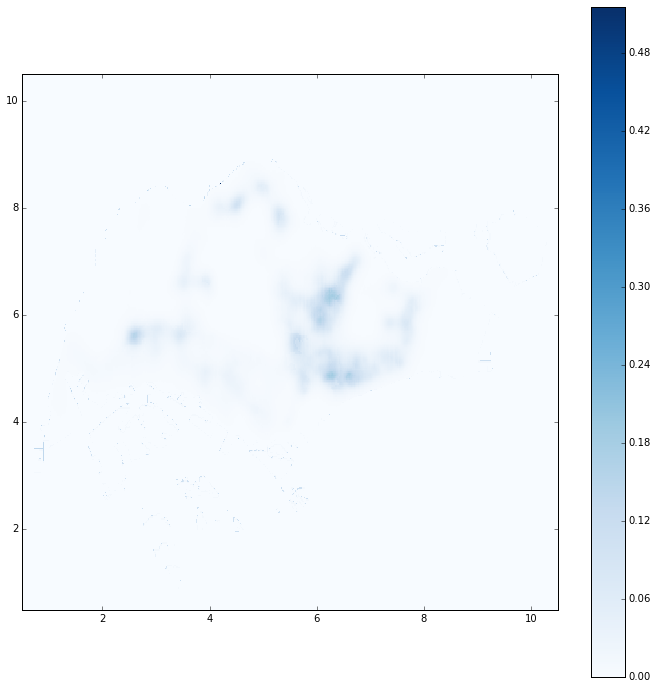

In [18]:
fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_l, interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.savefig('logit.png')

##### Random Forest using Gridsearch and PCA

In [19]:
pca = PCA()
forest = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])

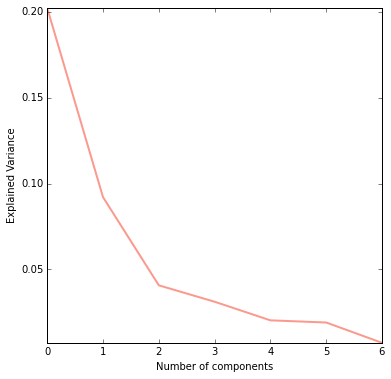

In [20]:
# Show components before running the pipeline
pca.fit(X_train.as_matrix())
plt.figure(1, figsize=(6, 6))
plt.plot(pca.explained_variance_, linewidth=2, c='salmon', alpha=0.8)
plt.axis('tight')
plt.xlabel('Number of components');
plt.ylabel('Explained Variance');

In [38]:
# Define the parameter for which the optimal value should be picked by GridsearchCV
max_features = ['auto','sqrt','log2']
criterion = ['gini','entropy']
n_estimators = [500,1000,5000] # Check some possible estimators

In [22]:
# Initiate the grid search
#estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,
#                    forest__n_estimators=n_estimators, forest__criterion=criterion,
#                    forest__max_features=max_features),iid=True,cv=5,refit=True,scoring='roc_auc')

In [23]:
# Parameters that can be set
#estimator.get_params().keys()

In [24]:
#%%time
# This takes considerable time
#estimator.fit(X_train, Y_train)
#print estimator.best_estimator_
#print estimator.best_params_
#print estimator.best_score_

In [ ]:
#plt.figure(1, figsize=(6, 6))
#plt.plot(pca.explained_variance_, linewidth=2, c='salmon', alpha=0.8)
#plt.axis('tight')
#plt.xlabel('Number of components');
#plt.ylabel('Explained Variance');
#plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
#            linestyle=':', label='Number of components chosen')
#plt.legend(prop=dict(size=10))
#plt.xlim(0,5.0)

***Since the best PCA picks 3 components, we will not perform PCA in the manual approach***

##### Manual Random Forest

In [37]:
max_features

['log2', 'sqrt', 'log2']

In [41]:
def get_results(max_features,criterion,X,Y): #,n_estimators
    kf = KFold(n=len(X), n_folds=4, shuffle=True, random_state=21)
    d = []
    for train_index, test_index in kf:
        for rf_features,criter in itertools.product(max_features,criterion): #,rf_estimators,n_estimators
            X_tr, X_test = X[train_index], X[test_index]
            X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
            Y_tr, Y_test = Y[train_index], Y[test_index]
            Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
            del X_tr
            del Y_tr
            forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=criter,
                    max_depth=None, max_features=rf_features, max_leaf_nodes=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                    oob_score=False, random_state=21, verbose=0,
                    warm_start=False)
            forest.fit(X_train,Y_train)
            forest_pred = forest.predict(X_validation)
            name = '%s,%s,%s'%(str(rf_features),str(criter),str(100))
            d.append((name,roc_auc_score(Y_validation,forest_pred),X_train,X_test,Y_train,Y_test))
    return sorted(d, key=lambda tup: tup[1])[-1]

In [45]:
%%time
# Get the best parameters
# Based on a smaller sample
best = get_results(max_features,criterion,X[['BusStop','Street','Water']].as_matrix(),Y.as_matrix())
best_params,X_train_best,X_test_best,Y_train_best,Y_test_best = best[0].split(','),best[2],best[3],best[4],best[5]

# Run RF
forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=best_params[1],
                max_depth=None, max_features=best_params[0], max_leaf_nodes=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=int(best_params[2]), n_jobs=-1,
                oob_score=False, random_state=21, verbose=0,
                warm_start=False)
forest.fit(X_train_best,Y_train_best)

auto
auto
sqrt
sqrt
log2
log2
auto
auto
sqrt
sqrt
log2
log2
auto
auto
sqrt
sqrt
log2
log2
auto
auto
sqrt
sqrt
log2
log2
CPU times: user 3min 11s, sys: 4.6 s, total: 3min 16s
Wall time: 3min 2s


In [47]:
best_params

['log2', 'gini', '100']

In [46]:
#Data_filt['LabelsRF'] = forest.predict(X)
# Get results
print accuracy_score(Y_test_best,forest.predict(X_test_best))
print roc_auc_score(Y_test_best,forest.predict(X_test_best))

0.989283465919
0.70496903115


#### Manual RF without gridsearch

In [48]:
# Define the parameter for which the optimal value should be picked by GridsearchCV
max_features = 'log2'
criterion = 'gini'
n_estimators = 1000 # Check if this number of estimators improves performance

In [49]:
%%time
# http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
kf = KFold(n=len(X), n_folds=6, shuffle=True, random_state=21)
d = []
for train_index, test_index in kf:
    X_tr, X_test = X.as_matrix()[train_index], X.as_matrix()[test_index]
    X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
    Y_tr, Y_test = Y.as_matrix()[train_index], Y.as_matrix()[test_index]
    Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
    del X_tr
    del Y_tr
    forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion=criterion,
            max_depth=None, max_features=max_features, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=-1,
            oob_score=False, random_state=21, verbose=0,
            warm_start=False)
    forest.fit(X_train,Y_train)
    forest_pred = forest.predict(X_validation)
    d.append((roc_auc_score(Y_validation,forest_pred),X_train,X_test,Y_train,Y_test))

CPU times: user 30min 35s, sys: 23.2 s, total: 30min 58s
Wall time: 4min 28s


In [50]:
print sorted(d, key=lambda tup: tup[0])[-1][0]

0.803121797463


***Using more forest estimators increases AUC to 80%.***

In [60]:
print accuracy_score(Y_test,forest.predict(X_test))

0.992037601408


In [52]:
Data_filt['LabelsRF'] = forest.predict(X)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [53]:
print confusion_matrix(Y, Data_filt['LabelsRF'])

[[275592    548]
 [   982   2446]]


In [54]:
Data_filt.LabelsRF.value_counts()

0    276574
1      2994
Name: LabelsRF, dtype: int64

In [62]:
print X.columns
print forest.feature_importances_

Index([u'BusStop', u'Lot', u'Park', u'Population', u'Street', u'Trash',
       u'Water'],
      dtype='object')
[ 0.18132959  0.14441587  0.12725184  0.04284686  0.14916111  0.19986581
  0.15512892]


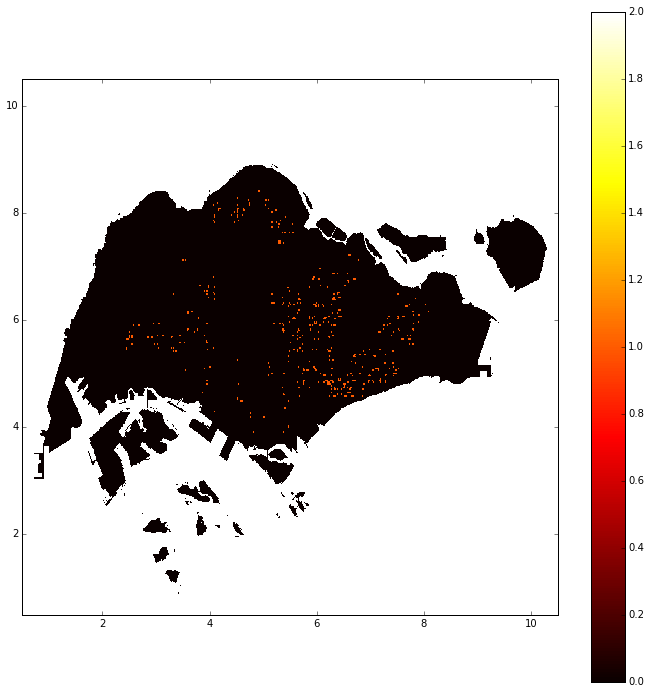

In [55]:
#0 disease, 1 no disease, 2 outside singapore 
matrix = np.zeros((m,n))+2
for M in Data_filt.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=Data_filt.LabelsRF[M]
m_l=matrix.tolist()
fig, ax = subplots(figsize=(12, 12))
plt.imshow(m_l, interpolation='nearest', cmap='hot', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.savefig('RF.png')